# Location-Based Social Network
Gowalla is a location-based social network where users "check in" to various locations. A check-in is the action of recording a user's physical presence at a specific real-world location, and a spot is the digital representation of that real-world location within the network. 

The dataset contains friend links and a complete check-in history for each user (with geographic coordinates).

Dataset source: https://snap.stanford.edu/data/loc-Gowalla.html

---

This notebook focuses on building a real-world link prediction pipeline, introducing:
* Temporal Dynamics: Using a time-based split to predict future links based on past data.
* Large-Scale Data Handling: Applying efficient EDA and sampling techniques suitable for a larger graph.
* Node Embedding: Training Node2Vec to automatically learn feature representations from the graph structure.
* Advanced Feature Engineering: Combining topological features, engineered node attributes (from geographic check-in data), and learned embeddings.
* Model Comparison: Evaluating and comparing baseline models with more powerful ensemble models.

## Initialization

In [1]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
from folium.plugins import HeatMap

import collections
import sys
import powerlaw
from math import radians, sin, cos, sqrt, atan2

sys.path.append('../')

from utils import plot


In [2]:
edges_path = 'data/Gowalla_edges.txt'
features_path = 'data/Gowalla_totalCheckins.txt'

In [3]:
G = nx.read_edgelist(edges_path, nodetype=int)

In [4]:
column_names = ['user', 'check-in_datetime', 'latitude', 'longitude', 'location_id']

try:
    df = pd.read_csv(features_path, sep='\t', names=column_names)
    df['check-in_datetime'] = pd.to_datetime(df['check-in_datetime'])

    print("DataFrame created successfully")

except FileNotFoundError:
    print(f"Error: The file '{features_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

DataFrame created successfully


### Functions Definition

In [75]:
def plot_distribution(data, title, xlabel, hist_bins=50, hist_y_log=True, hist_x_log=False, show_powerlaw=False):
    """
    Plots both a histogram with a log y-axis and a CCDF on a log-log scale.
    Optionally adds a power-law fit to the CCDF.
    """

    if isinstance(data, list):
        data = pd.Series(data)

    _, (plt1, plt2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Histogram with Log Y-axis
    plt1.hist(data, bins=hist_bins, color='skyblue', edgecolor='black')
    if (hist_y_log):
        plt1.set_yscale('log')
    if (hist_x_log):
        plt1.set_xscale('log')
    plt1.set_title(f'{title} (Histogram)', fontsize=16)
    plt1.set_xlabel(f'{xlabel} {"(Log Scale)" if hist_x_log else ""}', fontsize=14)
    plt1.set_ylabel(f'Frequency {"(Log Scale)" if hist_y_log else ""}', fontsize=14)
    plt1.grid(True, which="both", ls="--", linewidth=0.5)
    plt1.axvline(data.mean(), color='r', linestyle='--', label=f'Mean: {data.mean():.2f}')
    plt1.axvline(data.median(), color='g', linestyle='--', label=f'Median: {data.median():.2f}')
    plt1.legend()

    # Plot 2: CCDF on a Log-Log Scale
    raw_values = data.values
    total_count = len(raw_values)

    value_frequencies = collections.Counter(raw_values)
    sorted_values = sorted(value_frequencies.keys())
    value_counts = [value_frequencies[val] for val in sorted_values]

    cumulative_counts = np.cumsum(value_counts)
    ccdf_y = 1 - cumulative_counts / total_count

    plt2.loglog(sorted_values, ccdf_y, marker='o', linestyle='none', markersize=5, label='CCDF')

    # Add power-law fit
    if show_powerlaw:
        fit = powerlaw.Fit(raw_values, discrete=True, verbose=False)
        x_ccdf, _ = fit.ccdf()
        fit_line_y = fit.power_law.ccdf(x_ccdf)
        plt2.loglog(x_ccdf, fit_line_y, color='red', linestyle='-', linewidth=2,
                    label=f'Fitted Power-Law (α={fit.alpha:.2f}, xmin={int(fit.xmin)})') #type: ignore

    plt2.set_title(f'{title} (CCDF - Log-Log Scale)', fontsize=16)
    plt2.set_xlabel(xlabel, fontsize=14)
    plt2.set_ylabel('P(X ≥ k)', fontsize=14)
    plt2.grid(True, which="both", ls="--", linewidth=0.5)
    if show_powerlaw:
        plt2.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


## Exploratory Data Analysis (EDA)

### Graph Topology

In [29]:
density = nx.density(G)

print(G)
print(f'Average degree: {sum(dict(G.degree).values()) / len(G.nodes):.1f}')
print(f'Max degree: {max(dict(G.degree).values())}')
print(f'Min degree: {min(dict(G.degree).values())}')
print(f'Density: {density:.8f}')

Graph with 196591 nodes and 950327 edges
Average degree: 9.7
Max degree: 14730
Min degree: 1
Density: 0.00004918


In [30]:
# Connected Components
print("Number of connected components:", nx.number_connected_components(G))

Number of connected components: 1


In [32]:
# Clustering
print(f'Average Local Clustering: {nx.average_clustering(G):.4f}')
print(f'Transitivity: {nx.transitivity(G):.4f}')

Average Local Clustering: 0.2367
Transitivity: 0.0235


In [33]:
# Calculating Diameter is infeasible with a graph this large
# We can take the measure directly from the SNAP dataset page
print('Diameter: 14')
print('90-percentile effective diameter: 5.7')

Diameter: 14
90-percentile effective diameter: 5.7


In [34]:
# Assortativity
print(f'Degree Assortativity: {nx.degree_assortativity_coefficient(G):.2f}')

Degree Assortativity: -0.03


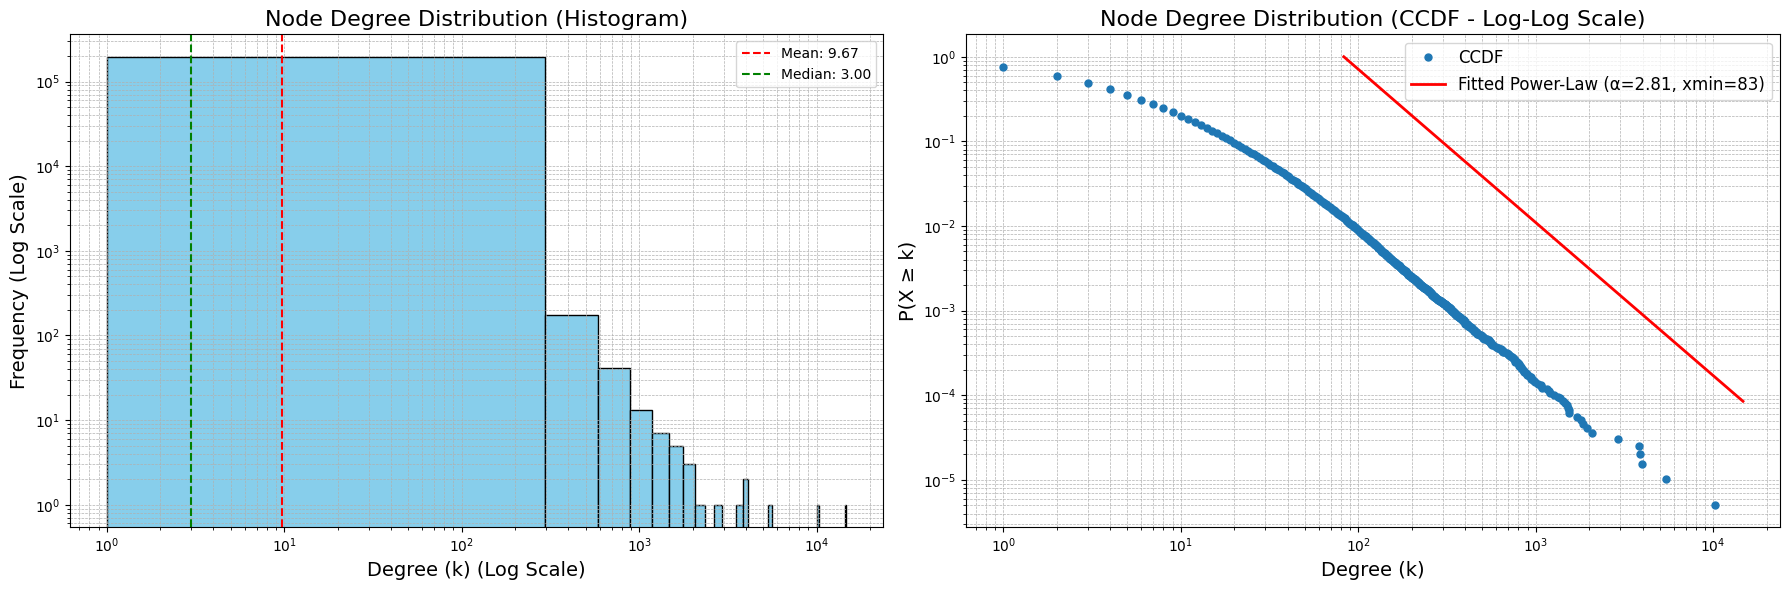

In [76]:
degrees = [G.degree(n) for n in G.nodes()]
plot_distribution(degrees, 'Node Degree Distribution', 'Degree (k)', hist_x_log=True, show_powerlaw=True)

#### Insights

**Size**  
With ~200 000 nodes (users) and ~1 000 000 connections (friendships between users) this is an extremely sparse network.

**Connected Components**  
The entire network is a single connected component, which is somewhat unusual to have in a social network. The data, as reported in the SNAP dedicated page, has been collected from the Gowalla public API, and is not reported if the dataset include only a connected component. According to sources<sup>[[1][1]] [[2][2]]</sup>, by late 2010 Gowalla had approximately 600 000 members, which could confirm the hypothesis that the dataset is reporting only a connected component (probably the largest). Further investigation will be done by inspecting the number of edges of new users over time. <span style="color:yellow">(TODO)</span>

[1]: https://web.archive.org/web/20101205020126/http://content.usatoday.com/communities/technologylive/post/2010/12/the-latest-from-gowalla-is-worth-checking-out/1
[2]: https://en.wikipedia.org/wiki/Gowalla

**Degree**  
The degree analysis reported an heavy-tailed degree distribution with many users that have a low degree and some hubs that have over 10 000 connections. The Complementary Cumulative Distribution Function (CCDF) with Log-Log scale plotted a straight line, confirming the presence of a power law (for degree values >= 83).

**Clustering**  
There is a moderate (~23%) probability that two friends of a user are also friends with each other, confirming the presence of tight local cluster, while the global structure is loosely connected.

**Distances**  
A diameter of 14 and a 90th percentile of ~6 indicates the presence of a small-world property.

### Check-Ins Features

In [36]:
print(df.head(10))

   user         check-in_datetime   latitude  longitude  location_id
0     0 2010-10-19 23:55:27+00:00  30.235909 -97.795140        22847
1     0 2010-10-18 22:17:43+00:00  30.269103 -97.749395       420315
2     0 2010-10-17 23:42:03+00:00  30.255731 -97.763386       316637
3     0 2010-10-17 19:26:05+00:00  30.263418 -97.757597        16516
4     0 2010-10-16 18:50:42+00:00  30.274292 -97.740523      5535878
5     0 2010-10-12 23:58:03+00:00  30.261599 -97.758581        15372
6     0 2010-10-12 22:02:11+00:00  30.267910 -97.749312        21714
7     0 2010-10-12 19:44:40+00:00  30.269103 -97.749395       420315
8     0 2010-10-12 15:57:20+00:00  30.281120 -97.745211       153505
9     0 2010-10-12 15:19:03+00:00  30.269103 -97.749395       420315


In [37]:
print(f'DataFrame with {df.shape[0]} rows and {df.shape[1]} columns')

print('\nColumns datatypes:')
print(df.dtypes)

DataFrame with 6442892 rows and 5 columns

Columns datatypes:
user                               int64
check-in_datetime    datetime64[ns, UTC]
latitude                         float64
longitude                        float64
location_id                        int64
dtype: object


In [38]:
df.isna().sum()

user                 0
check-in_datetime    0
latitude             0
longitude            0
location_id          0
dtype: int64

#### Locations and Coordinates Sanity Check

Before working with the location and coordinates we need to assure that this data are well-formed and robust.

In [ ]:
# Merge latitude and longitude in a tuple
df['coordinates'] = list(zip(df['latitude'], df['longitude']))

In [ ]:
# Check the relation cardinality between Locations-Coordinates
unique_coords_for_each_location = df.groupby('location_id')['coordinates'].nunique().loc[lambda x: x != 1]
unique_location_for_each_coord = df.groupby('coordinates')['location_id'].nunique().loc[lambda x: x != 1]

print(f'There are {unique_coords_for_each_location.shape[0]} location with multiple coordinates associated.')
print(f'There are {unique_location_for_each_coord.shape[0]} coordinates with multiple location associated.')

There are 297 location with multiple coordinates associated.
There are 17120 coordinates with multiple location associated.


This finding is critical: there is a many-to-many association between locations and coordinates. This means that at the moment the location is not a perfect information to define a unique physical "place" in the real world.
The reasons behind this discrepancy could be multiple:
- GPS inaccuracy
- If the location is big enough it could have been represented with different coordinates
- Locations could have moved to a different location, resulting in different coordinates over time
- If coordinates are user generated and not linked to a location by Gowalla itself, multiple users could have created multiple coordinates for the same place
- If two locations extend vertically in the same building then they will have the same coordinates

It's also worth to node that each decimal place in a coordinate adds about a magnitude more precision. This means that if each decimal degree is equal to 111 kilometers at the equator, a value in decimal degrees with a precision of 4 decimal places is precise to 11.1 metres at the equator, and a value in decimal degrees with a precision of 10 decimal places is precise to ~11 micrometers at the equator<sup>[[1][1]]</sup>: this is how the data is represented in the dataset. Is safe to say that no GPS has this precision, and the data provided could have been subject to computation artifacts (floating-point).

Whatever the cause is, we need to have a more robust association between locations and coordinates.

[1]: <https://en.wikipedia.org/wiki/Decimal_degrees#Precision>

In [45]:
# Find most frequent coordinates per location
most_frequent_coords = df.groupby(['location_id', 'coordinates']).size().groupby(level=0).idxmax().map(lambda x: x[1])

# Calculate deviations from most frequent coordinates
df['lat_mode_deviation'] = (df['latitude'] - df['location_id'].map(most_frequent_coords).apply(lambda x: x[0])).abs()
df['lon_mode_deviation'] = (df['longitude'] - df['location_id'].map(most_frequent_coords).apply(lambda x: x[1])).abs()

# Create final locations dataframe
locations_df = pd.DataFrame({
    'checkin_count': df['location_id'].value_counts(),
    'most_frequent_coordinates': most_frequent_coords,
    'lat_mode_deviation': df.groupby('location_id')['lat_mode_deviation'].mean(),
    'lon_mode_deviation': df.groupby('location_id')['lon_mode_deviation'].mean()
})
locations_df.index.name = 'location_id'

In [ ]:
# Extract locations with deviation
locations_with_deviation = locations_df[(locations_df['lat_mode_deviation'] != 0) | (locations_df['lon_mode_deviation'] != 0)]

print(f"There are {locations_with_deviation.shape[0]} ({locations_with_deviation.shape[0]/locations_df.shape[0]*100:.2f}%) "
      "locations with coordinates that deviates from their most frequent position.\n"
      f"Those locations appears in {df[df['location_id'].isin(locations_with_deviation.index.to_series())].shape[0]} checkins total."
)

locations_df.sort_values(by=['lat_mode_deviation', 'lon_mode_deviation'], ascending=False).head(10)

There are 297 (0.02%) locations with coordinates that deviates from their most frequent position.
Those locations appears in 6360 checkins total.


,checkin_count,most_frequent_coordinates,lat_mode_deviation,lon_mode_deviation
location_id,,,,
5346854,9,"(34.84795, -82.40195)",1.160431,0.372884
4242925,2,"(-6.2176949346, 106.8368697166)",0.017364,0.003111
479809,9,"(40.505185, -86.184998)",0.012101,0.025099
3799363,6,"(39.8597148178, -75.2531719208)",0.010054,0.002449
1203730,2,"(29.8156998257, -95.6737518311)",0.006843,0.001709
780207,23,"(30.3690646053, -97.8614709375)",0.005260,0.002832
100640,29,"(32.7361921167, -97.3607257167)",0.002978,0.002594
1702478,21,"(59.3200262689, 18.0596297979)",0.002493,0.000322
794059,2,"(27.9195062762, -82.4950038764)",0.002446,0.001491


#### Temporal Sanity Check

We need to make sure the temporal data is consistent: the activity should grow over time in a continuos way.

Data ranges from 2009-02-04 05:17:38+00:00 to 2010-10-23 05:22:06+00:00


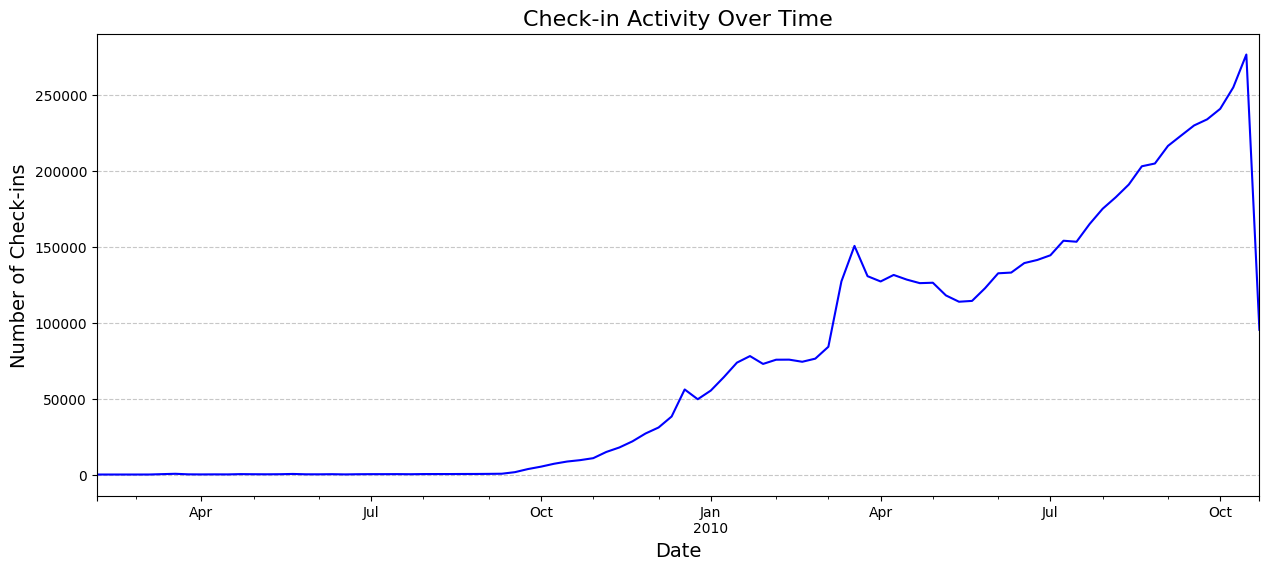

In [83]:
df_time = df.set_index('check-in_datetime')

# Count the number of check-ins (per week)
checkins_over_time = df_time.resample('W').size()

# Plotting
plt.figure(figsize=(15, 6))
checkins_over_time.plot(color='b')

plt.title('Check-in Activity Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Check-ins', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

print(f"Data ranges from {df['check-in_datetime'].min()} to {df['check-in_datetime'].max()}")
plt.show()

#### Check-Ins Distribution

In [20]:
# Save locally the check-in heatmap
heat_data = df[['latitude', 'longitude']].values.tolist()

map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

HeatMap(heat_data, radius=15, blur=10).add_to(m)

m.save("gowalla_heatmap.html")

Number of users with at least one check-in: 107092 (54.47%)
Most active user made 2175 check-ins.
Average user has ~60.16 check-ins.



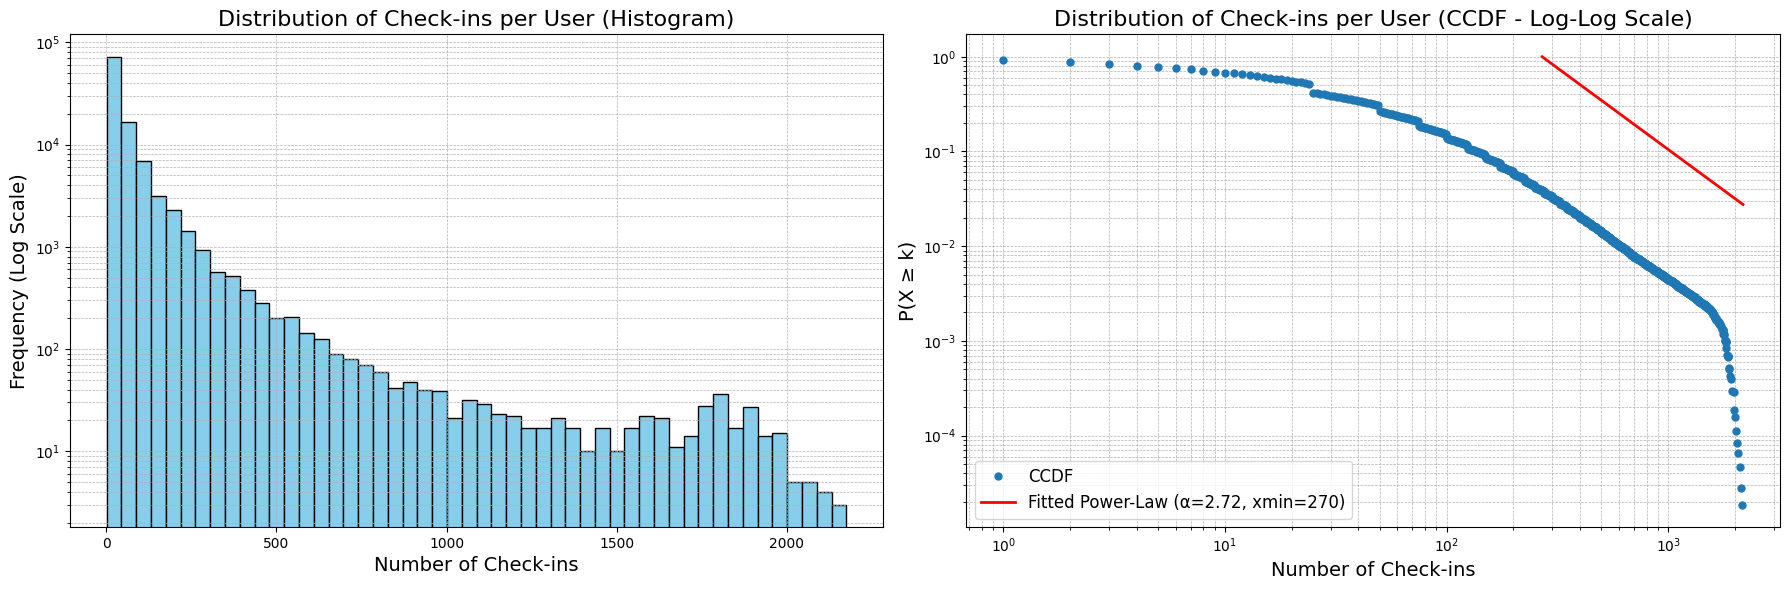

In [ ]:
# Distribution of Check-ins per User
checkins_per_user = df['user'].value_counts()

print(f'Number of users with at least one check-in: {len(checkins_per_user)} ({len(checkins_per_user)/G.number_of_nodes()*100:.2f}%)')
print(f'Most active user made {checkins_per_user.max()} check-ins.')
print(f'Average user has ~{checkins_per_user.mean():.2f} check-ins.\n')


plot_distribution(
    checkins_per_user,
    'Distribution of Check-ins per User',
    'Number of Check-ins',
    show_powerlaw=True
)

Unique locations:               1280969
Most check-ins for a location:  5811
Average check-ins per location: 5.03
Median check-ins per location:  2.00
Least check-ins for a location: 1




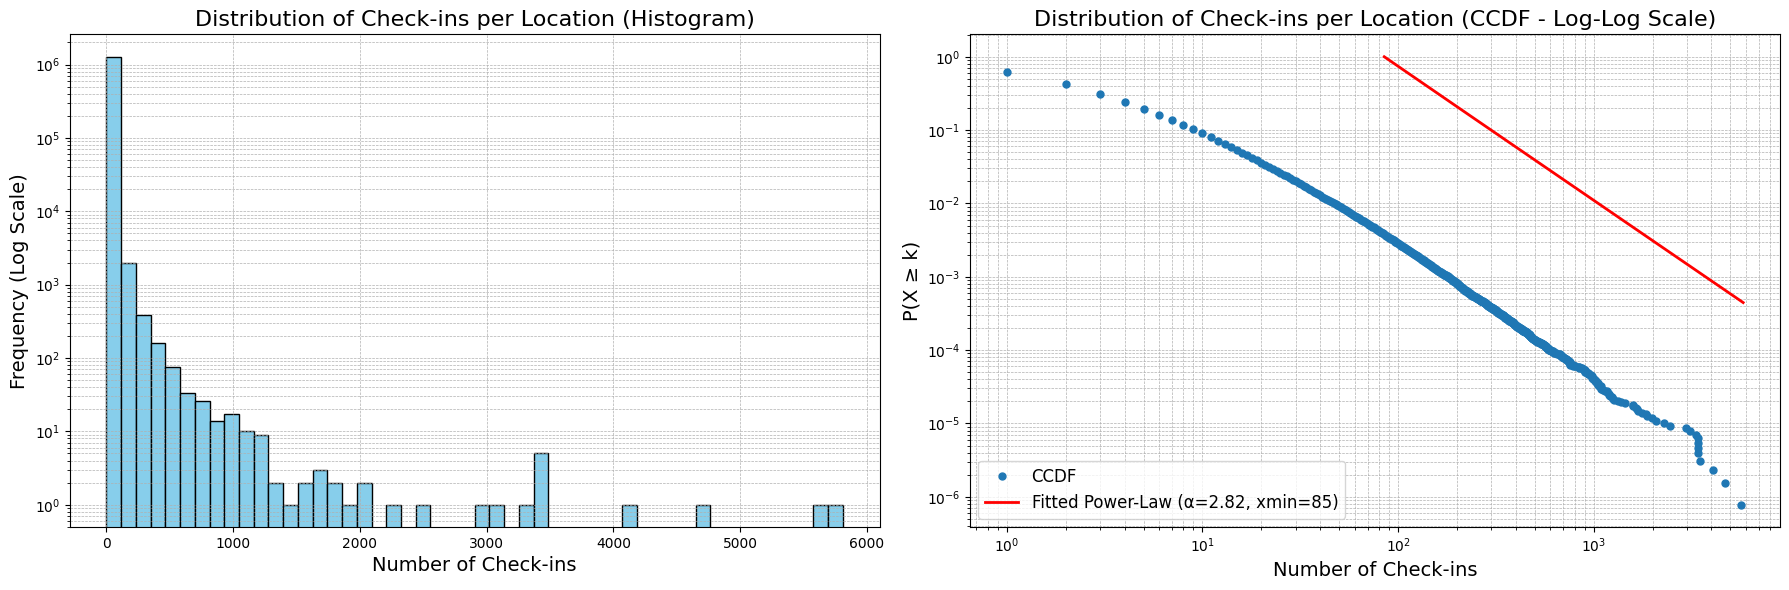

In [ ]:
# Distribution of Check-ins per Locations
checkins_per_location = df['location_id'].value_counts()

print(f'Unique locations:               {len(checkins_per_location)}')
print(f'Most check-ins for a location:  {checkins_per_location.max()}')
print(f'Average check-ins per location: {checkins_per_location.mean():.2f}')
print(f'Median check-ins per location:  {checkins_per_location.median():.2f}')
print(f'Least check-ins for a location: {checkins_per_location.min()}')

print('\n')
plot_distribution(
    checkins_per_location,
    'Distribution of Check-ins per Location',
    'Number of Check-ins',
    show_powerlaw=True
)

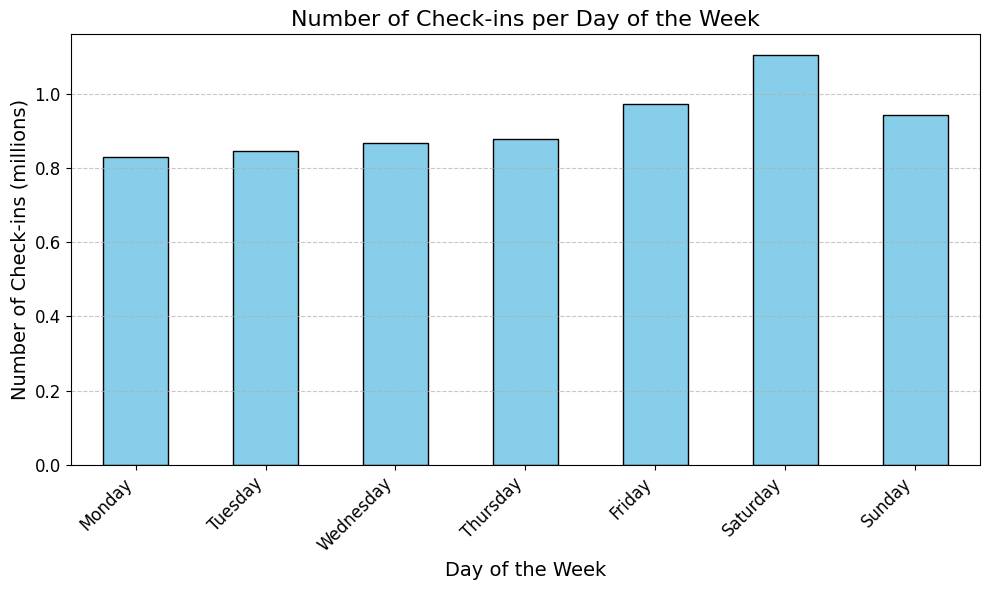

In [ ]:
# Number of Check-ins per Day of the Week

df['day_of_week'] = df['check-in_datetime'].dt.dayofweek

# Count check-ins for each day of the week
checkins_by_day = df['day_of_week'].value_counts().sort_index()
checkins_by_day = checkins_by_day / 1000000

# Map numerical day of week to names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
checkins_by_day.index = [day_names[i] for i in checkins_by_day.index] #type: ignore

# Plotting
plt.figure(figsize=(10, 6))
checkins_by_day.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Check-ins per Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Check-ins (millions)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Only horizontal grid lines
plt.tight_layout()
plt.show()

df = df.drop(columns=['day_of_week'])

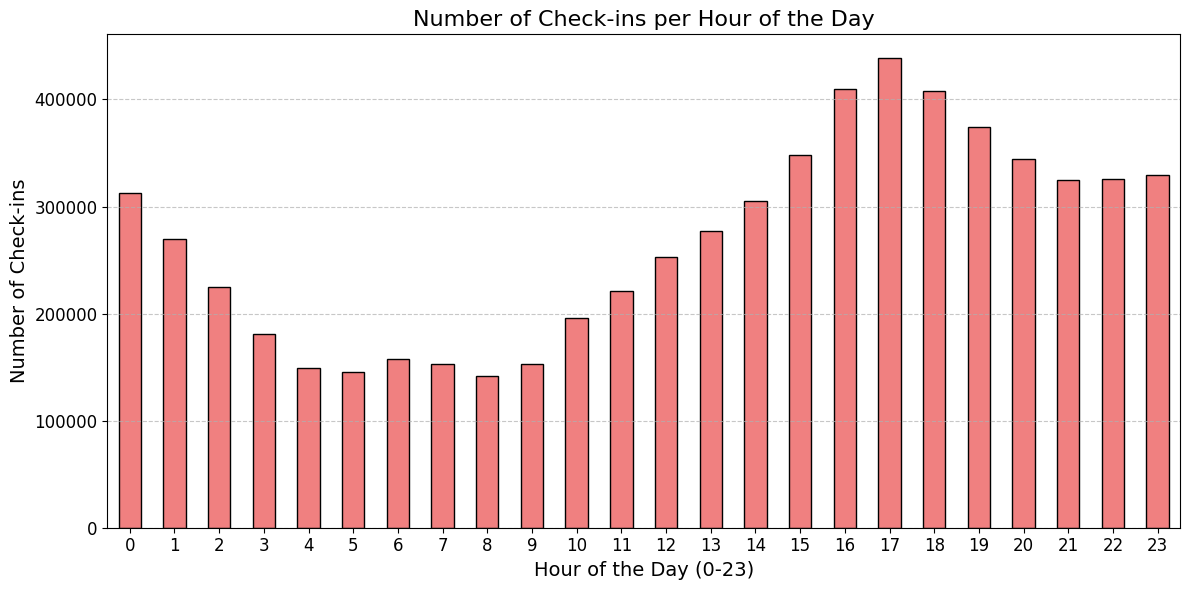

In [27]:
# Number of Check-ins per Hour of the Day

df['hour_of_day'] = df['check-in_datetime'].dt.hour

# Count check-ins for each hour of the day
checkins_by_hour = df['hour_of_day'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
checkins_by_hour.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Number of Check-ins per Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (0-23)', fontsize=14)
plt.ylabel('Number of Check-ins', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Only horizontal grid lines
plt.tight_layout()
plt.show()

df = df.drop(columns=['hour_of_day'])

#### Insights

**Locations and Coordinates Relation**
The first thing to notice is that coordinates have up to 10 decimal numbers, that is clearly an artifact of some kind as already explained. This high-precision numbers are part of a bigger problem: the many-to-many relation between coordinates and locations. To work safely we need to position each location in a unique position. This has been achieved by taking the mode (most frequent value) of coordinate for each location. The result had only 297 location which had high deviation from the mode: the highest had a massive average latitude deviation of 1.16, which is over 100km. Those locations could be removed as they are a small fraction of the total dataset, but are also a part of (noisy) information that could still have some prediction power.

**Date and Time Continuity**
The graph "Check-in Activity Over Time" clearly shows activity starting in late 2009, rising to a peak around late 2010, where the dataset snapshot stops. The data is continuous, with no major gaps, and have a slow start that takes 1/3 of total coverage. This plot provides a good visualization of a temporal train/test split.

**Distribution of Checkins**
The "*Distribution of Check-ins per User*" plot clearly shows the presence of super-users. Also it's important to note that less than half of total users have at least one check-in registered, meaning that for the remaining half only the graph topological structure could be used to predict friendship. The "*Distribution of Check-ins per Location*" plot also shows the presence of super-locations.

The bar chart "*Check-ins per Day of the Week*" shows a weekly cycle, with activity peaking on Fridays and Saturdays and being lowest on Monday. The bar chart "*Check-ins per Hour of the Day*" shows that there is also a cycle withing the hours with the peak reached at 5 PM and the lull in the early morning. This helps to assure the realism of the dataset, because it represents the real human behavioral patterns.

#### Pair-Wise ... TODO title

##### Home Location Inference

The goal here is to infer the user's home locations from GPS tracking of their movements trough check-in. The idea is that friends are more likely to be geographically close, i.e. if their inferred homes are close. 

There are different ways to infer a user home:
- Using heuristics and common sense assumptions (concept expanded later).
- Clustering Methods (DBSCAN, K-Means)
- Grid Methods 

TODO: chose what to do. IDEA: follow-up "Mobility Analysis" notebook implementing all three methods. Use pipelining libraries to save results? 